In [87]:
from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import yfinance as yf

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

## 3. The Data

In [299]:
start_date="2010-01-01"
raw_data=yf.download("GS",start=start_date)
raw_data.iloc[2105]


[*********************100%***********************]  1 of 1 completed


Open         2.436000e+02
High         2.458800e+02
Low          2.435000e+02
Close        2.439100e+02
Adj Close    2.268557e+02
Volume       1.928500e+06
Name: 2018-05-14 00:00:00, dtype: float64

In [326]:
dataset_ex_df=pd.DataFrame(raw_data["Close"])

In [319]:
dataset_ex_df.head()

,Close
Date,
2009-12-31,168.839996
2010-01-04,173.080002
2010-01-05,176.139999
2010-01-06,174.259995
2010-01-07,177.669998


In [317]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 3010 number of days in the dataset.


In [29]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))
                                    

Number of training days: 2105. Number of test days: 903.


TypeError: descriptor 'date' for 'datetime.datetime' objects doesn't apply to a 'int' object

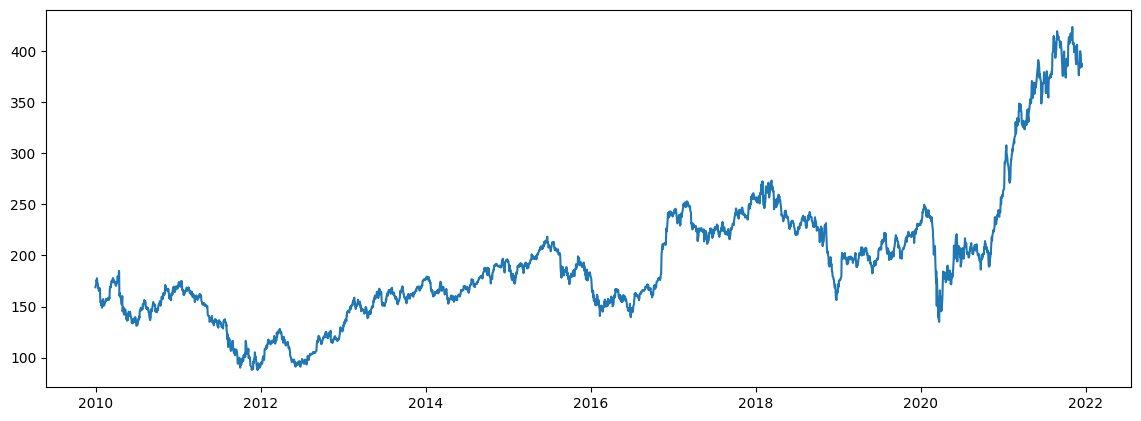

In [304]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df, label='Goldman Sachs stock')
plt.vlines(datetime.date(2018,5, 14), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

## 3.1 Correlated assets

In [158]:
competitor_df=yf.download("JPM MS",start=start_date)
competitor_df=competitor_df["Close"]
competitor_df

[*********************100%***********************]  2 of 2 completed


,JPM,MS
Date,,
2009-12-31,41.669998,29.600000
2010-01-04,42.849998,30.910000
2010-01-05,43.680000,32.040001
2010-01-06,43.919998,32.450001
2010-01-07,44.790001,32.919998
...,...,...
2021-12-07,162.570007,102.500000
2021-12-08,160.710007,101.250000
2021-12-09,160.460007,100.580002


In [159]:
global_df=yf.download("SPY ^FTSE ^N225 NDAQ ^VIX",start=start_date)
global_df=global_df["Close"]
global_df

[*********************100%***********************]  5 of 5 completed


,NDAQ,SPY,^FTSE,^N225,^VIX
Date,,,,,
2009-12-31,19.820000,111.440002,5412.899902,NaN,21.680000
2010-01-04,20.240000,113.330002,5500.299805,10654.790039,20.040001
2010-01-05,20.299999,113.629997,5522.500000,10681.830078,19.350000
2010-01-06,20.290001,113.709999,5530.000000,10731.450195,19.160000
2010-01-07,20.020000,114.190002,5526.700195,10681.660156,19.059999
...,...,...,...,...,...
2021-12-08,207.389999,469.519989,7337.399902,28860.619141,19.900000
2021-12-09,204.139999,466.350006,7321.299805,28725.470703,21.580000
2021-12-10,205.779999,470.739990,7291.799805,28437.769531,18.690001


In [86]:
eur_usd_df=pd.read_csv("HistoricalPrices.csv")
eur_usd_df

,Date,Open,High,Low,Close
0,12/10/21,1.1294,1.1324,1.1265,1.1318
1,12/09/21,1.1342,1.1348,1.1279,1.1293
2,12/08/21,1.1269,1.1357,1.1265,1.1343
3,12/07/21,1.1285,1.1300,1.1227,1.1267
4,12/06/21,1.1316,1.1320,1.1266,1.1286
...,...,...,...,...,...
3111,01/07/10,1.4411,1.4411,1.4308,1.4308
3112,01/06/10,1.4365,1.4411,1.4365,1.4411
3113,01/05/10,1.4413,1.4413,1.4365,1.4365
3114,01/04/10,1.4332,1.4413,1.4332,1.4413


In [305]:
dataset=pd.concat([dataset_ex_df,global_df,competitor_df],axis=1)
dataset=dataset.dropna()

## 3.2 Technical indicators

In [329]:

# Create 7 and 21 days Moving Average
dataset_ex_df['ma7'] = dataset_ex_df['Close'].rolling(window=7).mean()
dataset_ex_df['ma21'] = dataset_ex_df['Close'].rolling(window=21).mean()

# Create Bollinger Bands
dataset_ex_df['20sd'] = dataset_ex_df["Close"].rolling(20).std()
dataset_ex_df['upper_band'] = dataset_ex_df['ma21'] + (dataset_ex_df['20sd']*2)
dataset_ex_df['lower_band'] = dataset_ex_df['ma21'] - (dataset_ex_df['20sd']*2)

# Create Exponential moving average
dataset_ex_df['ema'] = dataset_ex_df['Close'].ewm(com=0.5).mean()


In [328]:
dataset_ex_df

,Close
Date,
2009-12-31,168.839996
2010-01-04,173.080002
2010-01-05,176.139999
2010-01-06,174.259995
2010-01-07,177.669998
...,...
2021-12-08,397.320007
2021-12-09,396.489990
2021-12-10,391.059998


In [154]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    plt.show()

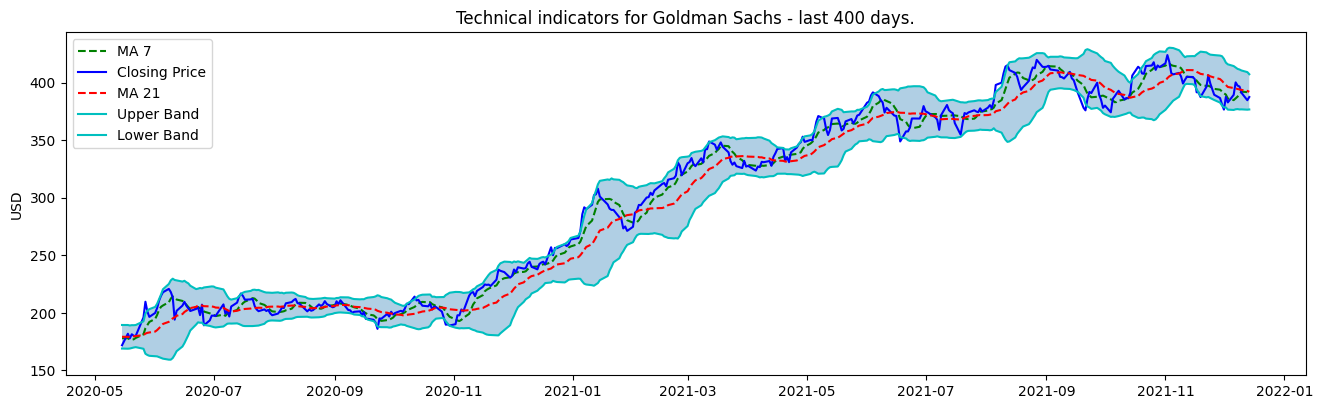

In [330]:
plot_technical_indicators(dataset_ex_df,400)

In [331]:
dataset.isna().sum()

Close    0
NDAQ     0
SPY      0
^FTSE    0
^N225    0
^VIX     0
JPM      0
MS       0
dtype: int64

## 3.3 Fundamental Analysis

## 3.4 Fourier transforms for trend analysis

In [196]:
dataset_ex_df=dataset_ex_df.dropna()
close_fft=np.fft.fft(np.asarray(dataset_ex_df.tolist()))
fft_df=pd.DataFrame({'fft':close_fft})
fft_df['absolute']=fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle']=fft_df['fft'].apply(lambda x: np.angle(x))
fft_df=fft_df.set_index(dataset_ex_df.index)
fft_df

,fft,absolute,angle
Date,,,
2009-12-31,582075.2156098+0.0000000j,582075.215698,0.000000
2010-01-04,19642.778980+75723.607597j,78229.812179,1.316989
2010-01-05,39792.524760+29114.495379j,49306.174745,0.631658
2010-01-06,55500.012319+19178.234529j,58720.150265,0.332708
2010-01-07,9886.022654+34374.620876j,35767.974562,1.290757
...,...,...,...
2021-12-07,7509.360749-14846.843044j,16637.885900,-1.102529
2021-12-08,9886.022654-34374.620876j,35767.974562,-1.290757
2021-12-09,55500.012319-19178.234529j,58720.150265,-0.332708


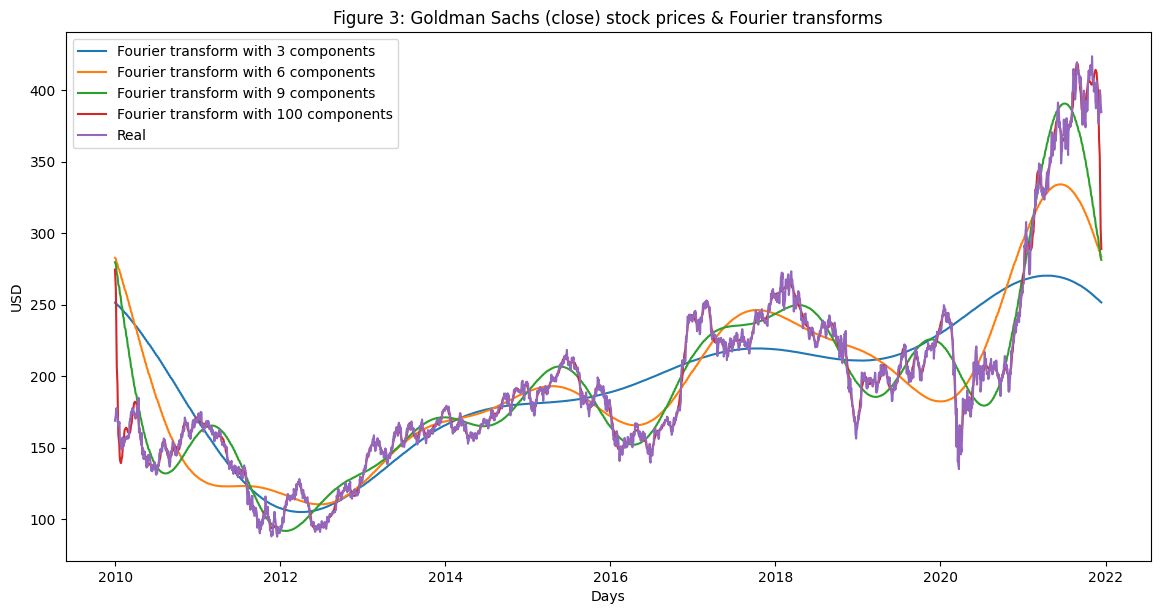

In [248]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(dataset_ex_df.index, np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(dataset_ex_df,  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

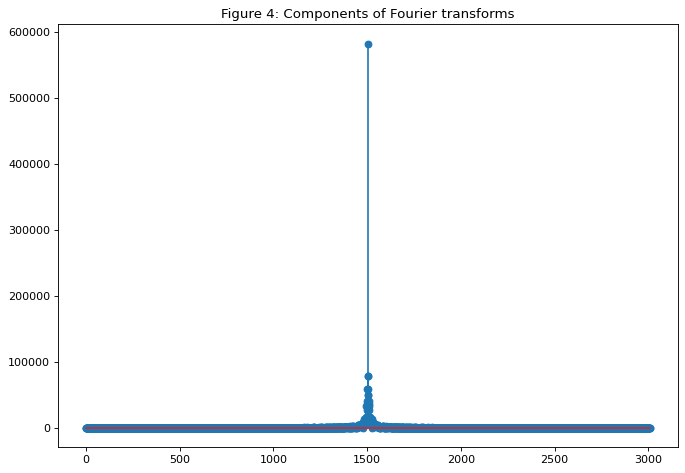

In [202]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [266]:
d={}
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    d["fft{0}".format(num_)]=np.fft.ifft(fft_list_m10)
fft_3=pd.DataFrame(d["fft3"]).set_index(dataset_ex_df.index)
fft_6=pd.DataFrame(d["fft6"]).set_index(dataset_ex_df.index)  
fft_9=pd.DataFrame(d["fft9"]).set_index(dataset_ex_df.index)
fft_3=fft_3.rename(columns={0:"fft_3"})
fft_6=fft_6.rename(columns={0:"fft_6"})
fft_9=fft_9.rename(columns={0:"fft_9"})

    

## 3.5 ARIMA as a feature

In [208]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(dataset_ex_df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print("p-value larger than 0.05 so we probably need to differentiate the time series before building the ARIMA model")

ADF Statistic: 0.028727
p-value: 0.960844
p-value larger than 0.05 so we probably need to differentiate the time series before building the ARIMA model


In [206]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = dataset_ex_df
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3009
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7965.426
Date:                Tue, 14 Dec 2021   AIC                          15942.851
Time:                        13:35:22   BIC                          15978.905
Sample:                             0   HQIC                         15955.818
                               - 3009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0373      0.010     -3.700      0.000      -0.057      -0.018
ar.L2          0.0562      0.011      5.074      0.000       0.034       0.078
ar.L3         -0.0266      0.012     -2.280      0.0

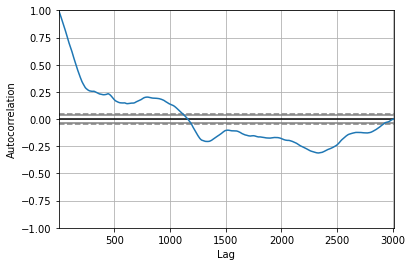

<Figure size 800x560 with 0 Axes>

In [217]:
pd.plotting.autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [218]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error

#comp. time: approx 2 minutes, 13 sec for 3000 obs
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [219]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 22.049


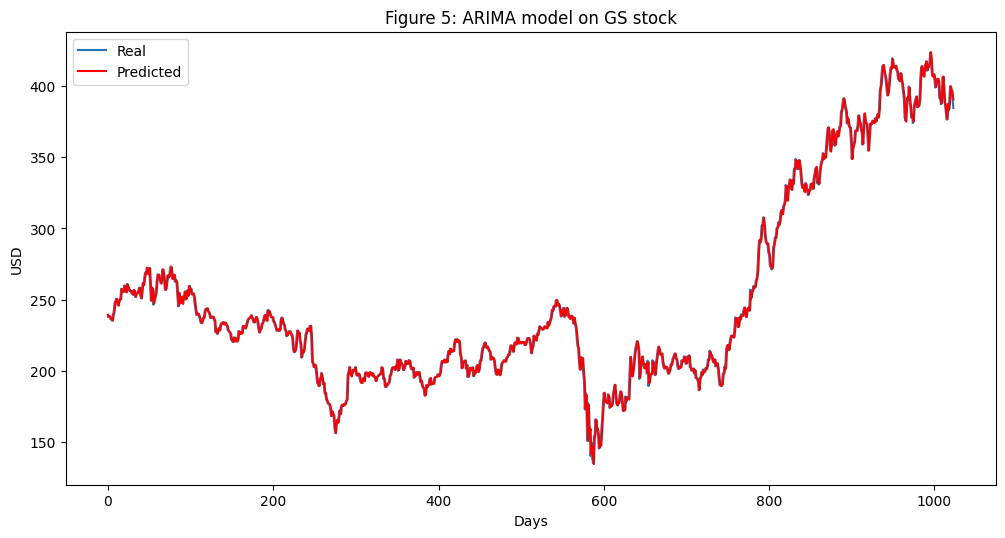

In [220]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

In [245]:
X=pd.DataFrame(X).set_index(dataset_ex_df.index)
X=X.rename(columns={0:"ARIMA"})
X

,ARIMA
Date,
2009-12-31,168.839996
2010-01-04,173.080002
2010-01-05,176.139999
2010-01-06,174.259995
2010-01-07,177.669998
...,...
2021-12-07,400.109985
2021-12-08,397.320007
2021-12-09,396.489990


In [355]:
dataset_total_df=pd.concat([dataset,X],axis=1)
dataset_total_df

,Close,NDAQ,SPY,^FTSE,^N225,^VIX,JPM,MS,ARIMA
Date,,,,,,,,,
2009-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.839996
2010-01-04,173.080002,20.240000,113.330002,5500.299805,10654.790039,20.040001,42.849998,30.910000,173.080002
2010-01-05,176.139999,20.299999,113.629997,5522.500000,10681.830078,19.350000,43.680000,32.040001,176.139999
2010-01-06,174.259995,20.290001,113.709999,5530.000000,10731.450195,19.160000,43.919998,32.450001,174.259995
2010-01-07,177.669998,20.020000,114.190002,5526.700195,10681.660156,19.059999,44.790001,32.919998,177.669998
...,...,...,...,...,...,...,...,...,...
2021-12-07,400.109985,205.550003,468.279999,7339.899902,28455.599609,21.889999,162.570007,102.500000,400.109985
2021-12-08,397.320007,207.389999,469.519989,7337.399902,28860.619141,19.900000,160.710007,101.250000,397.320007
2021-12-09,396.489990,204.139999,466.350006,7321.299805,28725.470703,21.580000,160.460007,100.580002,396.489990


In [235]:
pd.Series(X)

0       168.839996
1       173.080002
2       176.139999
3       174.259995
4       177.669998
           ...    
3004    400.109985
3005    397.320007
3006    396.489990
3007    391.059998
3008    384.730011
Length: 3009, dtype: float64

## 3.6 Statistical checks

Test for heteroscedasticity, multicollinarity and serial correlation

## 3.7 Feature Engineering

In [268]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

Total dataset has 3009 samples, and 18 features.


## 3.7.1 Feature importance with XGBoost

In [271]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [352]:
#done with only the technical indicators in the example
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_total_df)

In [353]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [354]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:fft_3, fft_6, fft_9

In [335]:
eval_result = regressor.evals_result()

In [336]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

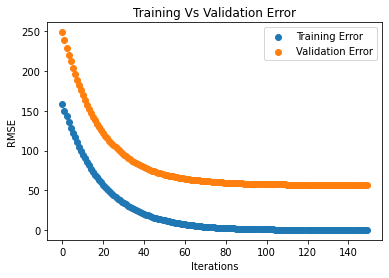

In [337]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

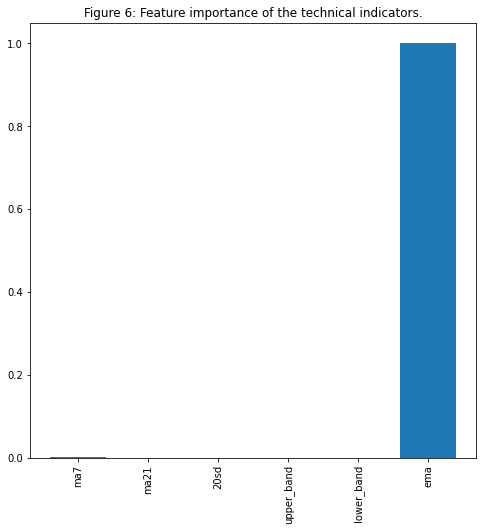

In [338]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

## 3.8 Extracting high-level features with Stacked Autoencoders

### 3.8.1 Activation function - GELU (Gaussian Error)


In [339]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

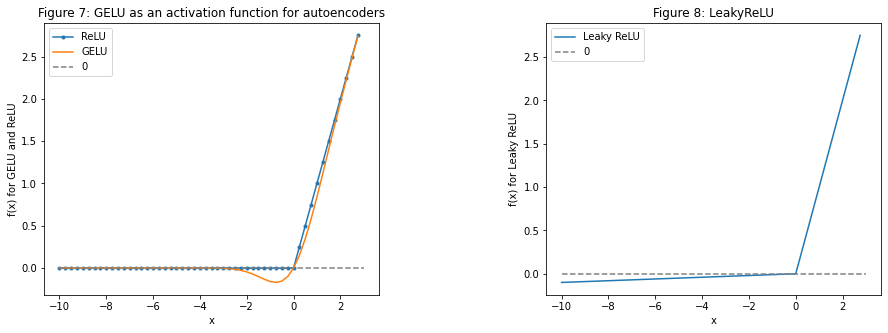

In [340]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

In [ ]:
import numpy as np
import mxnet as mx
import random
from config_celeba_cnn import input_shape
import glob
import cv2
import os


def GetData(ctx, data_folder):
    subdirs = [os.path.join(data_folder, o) for o in os.listdir(data_folder)
               if os.path.isdir(os.path.join(data_folder,o))]

    train_split = subdirs[: int(len(subdirs) * 0.95)]
    test_split = subdirs[int(len(subdirs) * 0.95):]
    train_iter = CelebAIter(ctx, input_shape, train_split)
    test_iter = CelebAIter(ctx, input_shape, test_split)
    return train_iter, test_iter


class CelebAIter(mx.io.DataIter):
    def __init__(self, ctx, data_shapes, data_array):
        super(CelebAIter, self).__init__()
        self.ctx = ctx
        self.data_shapes = data_shapes
        self.batch_size = data_shapes[0]

        self.data_array = data_array
        self.num_examples = len(data_array)

        self.num_batches = self.num_examples / self.batch_size
        self.cur_batch = 0
        self.flip = False
        self.reset()

    def __iter__(self):
        return self

    def reset(self):
        random.shuffle(self.data_array)
        self.cur_batch = 0

    def __next__(self):
        return self.next()

    def next(self):
        if self.cur_batch < self.num_batches:
            data = np.zeros(self.data_shapes, dtype=np.float32)

            for i in range(self.batch_size):
                index = self.cur_batch * self.batch_size + i
                indevidual_folder = self.data_array[index]
                indevidual_imgs = glob.glob(indevidual_folder + "/*.jpg")
                img_filename = random.choice(indevidual_imgs)
                img_filename = img_filename.replace('\\', '/')
                img_anno = img_filename[:-3]+"txt"

                with open(img_anno) as f:
                    anno_content = f.readlines()
                # you may also want to remove whitespace characters like `\n` at the end of each line
                anno_content = [x.strip() for x in anno_content]
                bbox = anno_content[0].split()[1:]
                bbox = [int(b) for b in bbox]

                img = cv2.imread(img_filename)
                img = img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :]
                img = cv2.resize(img, (input_shape[2], input_shape[2]), interpolation=cv2.INTER_LINEAR)
                img = img / 255.0 * 2.0 - 1.0
                img = np.swapaxes(img, 0, 2)
                img = np.swapaxes(img, 1, 2)
                img = img.astype('float32')

                data[i, :, :, :] = img[:]
                del img

            self.cur_batch += 1
            return mx.nd.array(data, ctx=self.ctx), None
        else:
            self.reset()
            raise StopIteration

In [341]:
batch_size = 64
n_batches = VAE_data.shape[0]/batch_size
VAE_data = VAE_data.values

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

NameError: name 'VAE_data' is not defined

### 3.8.2 Eigen portfolop with PCA

In [343]:
# We want the PCA to create the new components to explain 80% of the variance
pca = PCA(n_components=.8)

In [348]:
x_pca = StandardScaler()
x_pca.fit_transform()


StandardScaler()

In [349]:
X

,ARIMA
Date,
2009-12-31,168.839996
2010-01-04,173.080002
2010-01-05,176.139999
2010-01-06,174.259995
2010-01-07,177.669998
...,...
2021-12-07,400.109985
2021-12-08,397.320007
2021-12-09,396.489990
